## Метрики
+ длина текста
+ max min tf-idf
+ max и min косинусное расстояние между парами слов (соседних и не соседних, если успеем посчитать), tf-idf взвешенное (умножать каждое слово на tf-idf этого слова для этого документа),
+ вытащить 25 самых частотных слов из текста (слово с самым высоким tf-idf - классификация с помощью правил в зависимости от пересечения самых значимых слов для группы со словами в данном документе)
+ средний вектор текста сравнить со средними по каждой группе (взять центроид текста и сравнить с центроидом группы)
+ то же самое, только по 25 частотным словам


## Модели
+ логистическая регрессия
+ случайный лес (выкинуть матрицы текстов)
+ [xgboost](https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn)
+ классификация до и после понижения размерности фичей (только все инты) с помощью Principal Composition Analysis

Лучше всего работает случайный лес.

# Data Processing

In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib
%matplotlib inline
import random
import warnings

df = pd.read_csv('data.csv', index_col='id')
df.head()

,text,group
id,,
0,"Любезные братцы и сестрички, «Под Корень» зако...",podkoren
1,"Завтра, в воскресение, в сообществе появится п...",podkoren
2,За время существования нашего сообщества была ...,podkoren
3,"Жизнь продолжается и, как всегда, продолжается...",podkoren
4,На днях погиб наш автор и любимый братец Тимоф...,podkoren


In [253]:
import warnings
warnings.filterwarnings('ignore')

## Descriptive Statistics

In [3]:
df.describe(include=[np.object])

,text,group
count,2447,3000
unique,2429,5
top,Доброе утро!,kudah
freq,5,600


In [254]:
import nltk
import re
from pymystem3 import Mystem

nltk.download('punkt')
mystem_analyzer = Mystem()

lemmatized = []
unlemmatized = []

for doc in df['text']:
    text = re.sub("<br>", "", str(doc))
    word_list = nltk.word_tokenize(text)
    unlemmatized.append(word_list)
    lemmatized.append([mystem_analyzer.lemmatize(word)[0] for word in word_list])

[nltk_data] Downloading package punkt to /home/valeria/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [255]:
from itertools import chain

count_unlem = 0

for el in unlemmatized:
    count_unlem += len(el)

cont_lemmatized = list(chain.from_iterable(lemmatized))

print("Количество токенов в датасете:", count_unlem)
print("Количество уникальных лемм:", len(set(cont_lemmatized)))

Количество токенов в датасете: 692543
Количество уникальных лемм: 37248


In [256]:
words_per_doc = np.mean([len(text) for text in unlemmatized])
symbols_per_doc = np.mean([len(str(doc)) for doc in df["text"]])

print("Среднее количество слов на документ:", int(words_per_doc))
print("Среднее количество символов на документ:", int(symbols_per_doc))

Среднее количество слов на документ: 230
Среднее количество символов на документ: 1281


In [257]:
from nltk.corpus import stopwords
import pymorphy2 as pm2

pmm = pm2.MorphAnalyzer()
russian_stopwords = stopwords.words("russian")

# сюда добавить парсинг получше
def parse(text):
    text = re.sub(r'[^\w\s]','', str(text))
    text = re.sub("[0-9A-Za-z#_=]", "", text)
    text = [pmm.normal_forms(x)[0] for x in text.split() if x not in russian_stopwords]
    if text == [np.nan]:
        return(['nan'])
    return text

df['text'] = df['text'].apply(parse)

In [258]:
df.head(5)

,text,group
id,,
0,"[любезный, братец, сестричка, под, корень, зак...",podkoren
1,"[завтра, воскресение, сообщество, появиться, п...",podkoren
2,"[за, время, существование, наш, сообщество, со...",podkoren
3,"[жизнь, продолжаться, продолжаться, дорога, на...",podkoren
4,"[на, день, погибнуть, наш, автор, любимый, бра...",podkoren


## TF-IDF

In [9]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess

dct = Dictionary()

dct.add_documents(list(df["text"]))
corpus = []
for idx, row in df.iterrows():
    corpus.append(dct.doc2bow(row['text']))
tf_idf = TfidfModel(corpus)

In [10]:
vectors = [tf_idf[doc] for doc in corpus]

In [11]:
vectors = [{dct[el[0]]: el[1] for el in vector} for vector in vectors]
vectors[0]

{'антропология': 0.13193552536887726,
 'большой': 0.05344479063789524,
 'братец': 0.15032721936852053,
 'вдохнуть': 0.1552589573836702,
 'весь': 0.09518281651471602,
 'вечность': 0.12109074706973376,
 'воскликнуть': 0.12866292143201075,
 'вряд': 0.0921973472432415,
 'вывод': 0.08963642679724876,
 'выполнить': 0.09274880429267256,
 'выпустить': 0.10163798396933127,
 'глубоко': 0.09776731505494081,
 'говориться': 0.08528866133929136,
 'грань': 0.11552077925803443,
 'должный': 0.047119136143471956,
 'дорогой': 0.07444388304014787,
 'ещё': 0.03700306878934491,
 'закончиться': 0.09923202700494284,
 'знать': 0.042512466224095914,
 'и': 0.030564587722126505,
 'иметь': 0.15479264270676557,
 'исследование': 0.09574388920952373,
 'история': 0.05175899247409029,
 'итог': 0.15131470121113363,
 'конец': 0.05233391859077387,
 'корень': 0.16205688399197954,
 'который': 0.057524361579211584,
 'кто': 0.05415846801491459,
 'культурный': 0.08451657979140888,
 'литература': 0.07831455195453832,
 'любезный

хуй
хуй
хуй
хуй
хуй
хуй
хуй
хуй
хуй
хуй
хуй
хуй
хуй
хуй


## Embeddings

К нашему маленькому корпусу постов мы добавили большой (5.8 ГБ) кусок ГикРЯ.
Из-за проблем с вычислительной сложностью пришлось сократить размерность эмбеддингов до 100, что сильно уменьшило общее качество модели. 
Самыми эффективным признаком, полученным с помощью эмбеддингов, оказалось векторное сходство на 25 самых важных по TF-IDF словах.

In [ ]:
!wget "http://corpus.leeds.ac.uk/tools/ru/ruwac-parsed.out.xz"

In [12]:
import lzma
import os
from collections import Counter
from datetime import datetime
from gensim.corpora import Dictionary
from string import punctuation as punct
from string import ascii_letters as latin
from tqdm import tqdm
punct += '»«'

corpus_archive_filename = 'ruwac-parsed.out.xz'
corpus_filename = 'corpus.txt'
premodel_filename = 'small.model'
vocabulary_filename = 'freq.txt'
model_filename = 'full.model'
sample_directory = 'sample'
manual_filename = 'manual_metrics.csv'
df_filename = 'data.csv'
lsi_model_small_filename = 'small_lsi.model'
wordlist_filename = 'wordlist.json'
idfs_filename = 'idfs.json'

In [ ]:
with lzma.open(corpus_archive_filename, mode='rt', encoding='utf-8') as f:
    with open(corpus_filename, mode='w', encoding='utf-8') as t:
        current = []
        for line_number, line in enumerate(f):
            if line_number % 10000000 == 0:
                print(line_number, datetime.now().time(), file=open('archive_log.txt', 'a', encoding='utf-8'))
            l = line.split('\t')
            if len(l) == 7:
                lemm = l[3]
                sent = l[1]
                if sent == 'SENT':
                    if set(latin).intersection(set(''.join(current))) == set():
                        current.append('\n')
                        print(' '.join(current), file=t, end='')
                    current = []
                elif lemm not in punct:
                    current.append(lemm)

In [14]:
from gensim.models import Word2Vec

sentences = list(df["text"])

In [147]:
addition = "\n"

for sent in sentences:
    addition += " ".join(sent) + '\n'
    
with open(corpus_filename, mode='a', encoding='utf-8') as t:
    t.write(addition)

In [21]:
premodel.similarity('сестричка', 'убить')

0.92137635

In [22]:
def get_vocabulary(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            for word in line.split():
                yield word

def get_sentences(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            yield line.split()

In [23]:
from collections import Counter

word_freq = Counter(tqdm(get_vocabulary(corpus_filename)))

487263005it [04:24, 1842969.96it/s]


In [24]:
model = Word2Vec(sg=1, min_count=1, workers=1, size=100)

In [25]:
model.build_vocab_from_freq(word_freq)

In [26]:
model.train(get_sentences(corpus_filename), epochs=1, total_examples=len(word_freq))

(414160863, 487263005)

In [27]:
model.save("new_model")

In [15]:
model = Word2Vec.load('new_model')

In [17]:
model.similarity('сестричка', 'бля')

0.8574129

In [259]:
df['weighted_vec'] = pd.Series(np.nan, index=df.index)

В нашей модели мы сохранили низкочастотные слова.

In [260]:
defect_words = 0

def get_embs(word):
    global defect_words
    try:
        word_emb = model.wv[re.sub("ё", "е", str(word))]
    except KeyError:
        word_emb = np.zeros(100)
        defect_words += 1
    return word_emb

def doc_to_vec(doc, vector):
    vec = [get_embs(word) * vector[word] for word in doc]
    return vec

print("Not found in model:", defect_words)

Not found in model: 0


In [261]:
d2v = [doc_to_vec(df["text"][doc], vectors[doc]) for doc in range(len(df["weighted_vec"]))]
df['weighted_vec'] = pd.Series(d2v, index=df.index)

In [262]:
df['word_length'] = pd.Series([len(doc) for doc in df["text"]], index=df.index)

In [263]:
def symbol_length(doc):
    length = 0
    for word in doc:
        length += len(word)
    return length

df['symbol_length'] = pd.Series([symbol_length(doc) for doc in df["text"]], index=df.index)

In [264]:
def max_idf(vec):
    ret = -2
    for key in vec:
        if vec[key] > ret:
            ret = vec[key]
    return ret

def min_idf(vec):
    ret = 2
    for key in vec:
        if vec[key] < ret:
            ret = vec[key]
    return ret

df['max_idf'] = pd.Series([max_idf(vec) for vec in vectors], index=df.index)
df['min_idf'] = pd.Series([min_idf(vec) for vec in vectors], index=df.index)

df.head()

,text,group,weighted_vec,word_length,symbol_length,max_idf,min_idf
id,,,,,,,
0,"[любезный, братец, сестричка, под, корень, зак...",podkoren,"[[-0.024145605, 0.11946748, 0.261655, -0.06556...",107,701,0.357202,0.026378
1,"[завтра, воскресение, сообщество, появиться, п...",podkoren,"[[-0.05039152, 0.057766065, 0.103294566, -0.01...",161,1062,0.384330,0.015935
2,"[за, время, существование, наш, сообщество, со...",podkoren,"[[-0.05420818, 0.03600782, 0.068977825, -0.006...",118,829,0.220884,0.020886
3,"[жизнь, продолжаться, продолжаться, дорога, на...",podkoren,"[[-0.027693467, 0.072877966, 0.056998827, -0.0...",240,1712,0.213519,0.017622
4,"[на, день, погибнуть, наш, автор, любимый, бра...",podkoren,"[[-0.053390473, 0.04924318, 0.08710171, 0.0078...",233,1519,0.425739,0.020320


## local similarity metric

Here we will redifine cosine similarity because we are retarded

In [265]:
def cos_sim(v1, v2):
    if np.sum(v1) and np.sum(v2):
        return np.inner(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    else:
        return 0

In [266]:
def local_sym(vector_matrix):
    sym_list = []
    for i in range(len(vector_matrix)):
        if i != 0:
            sym_list.append(cos_sim(vector_matrix[i-1], vector_matrix[i]))
    return sym_list

def crutched_max(vec):
    if len(vec) == 0:
        return 0
    else:
        return max(vec)

def crutched_mean(vec):
    if len(vec) < 2:
        return 0
    else:
        return np.nanmean(vec)

In [267]:
df['max_loc_sym'] = pd.Series([crutched_max(local_sym(vec)) for vec in df['weighted_vec']], index=df.index)
df['mean_loc_sym'] = pd.Series([crutched_mean(local_sym(vec)) for vec in df['weighted_vec']], index=df.index)

In [268]:
source2id = {'podkoren': 0, 
             'telegony': 1,
             'kudah': 2,
             'ufo': 3, 
             'krishnaits': 4}

id2source = {v:k for k, v in source2id.items()}
df["group"] = df["group"].replace(source2id)

In [ ]:
df.to_csv("processed_data.csv", sep='\t', encoding='utf-8')

In [ ]:
df = pd.read_csv('processed_data.csv', index_col='id', sep='\t')

## vector centroids metric

In [271]:
import math

def vec_mean(vec):
    ret = np.nanmean(vec, axis=0)
    try:
        if math.isnan(ret):
            return np.zeros(100)
    except TypeError:
        return ret
    

df['av_vec'] = pd.Series([vec_mean(vec) for vec in df['weighted_vec']], index=df.index)

df.head()

,text,group,weighted_vec,word_length,symbol_length,max_idf,min_idf,max_loc_sym,mean_loc_sym,av_vec
id,,,,,,,,,,
0,"[любезный, братец, сестричка, под, корень, зак...",0,"[[-0.024145605, 0.11946748, 0.261655, -0.06556...",107,701,0.357202,0.026378,0.946426,0.841490,"[-0.026107866, 0.07318952, 0.12762639, -0.0193..."
1,"[завтра, воскресение, сообщество, появиться, п...",0,"[[-0.05039152, 0.057766065, 0.103294566, -0.01...",161,1062,0.384330,0.015935,0.946426,0.765385,"[-0.024511453, 0.06863122, 0.095399134, -0.010..."
2,"[за, время, существование, наш, сообщество, со...",0,"[[-0.05420818, 0.03600782, 0.068977825, -0.006...",118,829,0.220884,0.020886,0.939897,0.774720,"[-0.016985752, 0.05953634, 0.103179164, -0.019..."
3,"[жизнь, продолжаться, продолжаться, дорога, на...",0,"[[-0.027693467, 0.072877966, 0.056998827, -0.0...",240,1712,0.213519,0.017622,1.000000,0.761354,"[-0.01978085034856084, 0.041534033656342915, 0..."
4,"[на, день, погибнуть, наш, автор, любимый, бра...",0,"[[-0.053390473, 0.04924318, 0.08710171, 0.0078...",233,1519,0.425739,0.020320,0.946426,0.760231,"[-0.020464042243560854, 0.044302185241447994, ..."


In [272]:
gr_av_vecs = []
for i in tqdm(range(5)):  
    gr_df_vec = df[df['group'] == i]['weighted_vec']
    flat_vec_list = [item for sublist in gr_df_vec for item in sublist]
    gr_av_vecs.append(vec_mean(flat_vec_list))

100%|██████████| 5/5 [00:00<00:00,  4.97it/s]


In [273]:
for i in tqdm(range(5)):
    name = str(i)+'_vec_sim'
    df[name] = pd.Series([cos_sim(gr_av_vecs[i], vec) for vec in df['av_vec']], index=df.index)
df.loc[:, "av_vec":].head()

100%|██████████| 5/5 [00:00<00:00, 15.54it/s]


,av_vec,0_vec_sim,1_vec_sim,2_vec_sim,3_vec_sim,4_vec_sim
id,,,,,,
0,"[-0.026107866, 0.07318952, 0.12762639, -0.0193...",0.995296,0.995036,0.986709,0.993069,0.994959
1,"[-0.024511453, 0.06863122, 0.095399134, -0.010...",0.987928,0.988199,0.981296,0.989143,0.985511
2,"[-0.016985752, 0.05953634, 0.103179164, -0.019...",0.994437,0.991371,0.982577,0.993864,0.992621
3,"[-0.01978085034856084, 0.041534033656342915, 0...",0.996604,0.994633,0.991280,0.998163,0.994523
4,"[-0.020464042243560854, 0.044302185241447994, ...",0.995212,0.994752,0.992444,0.993032,0.995906


## top words intersection rule metric

In [274]:
import operator

df['top_25_words'] = pd.Series([set([el[0] for el in sorted(vectors[i].items(), key=operator.itemgetter(1))[-25:]]) for i in range(3000)], index=df.index)
df.head()

,text,group,weighted_vec,word_length,symbol_length,max_idf,min_idf,max_loc_sym,mean_loc_sym,av_vec,0_vec_sim,1_vec_sim,2_vec_sim,3_vec_sim,4_vec_sim,top_25_words
id,,,,,,,,,,,,,,,,
0,"[любезный, братец, сестричка, под, корень, зак...",0,"[[-0.024145605, 0.11946748, 0.261655, -0.06556...",107,701,0.357202,0.026378,0.946426,0.841490,"[-0.026107866, 0.07318952, 0.12762639, -0.0193...",0.995296,0.995036,0.986709,0.993069,0.994959,"{отмахнуться, прорастить, вечность, братец, на..."
1,"[завтра, воскресение, сообщество, появиться, п...",0,"[[-0.05039152, 0.057766065, 0.103294566, -0.01...",161,1062,0.384330,0.015935,0.946426,0.765385,"[-0.024511453, 0.06863122, 0.095399134, -0.010...",0.987928,0.988199,0.981296,0.989143,0.985511,"{выложить, пометка, братец, сложный, структурн..."
2,"[за, время, существование, наш, сообщество, со...",0,"[[-0.05420818, 0.03600782, 0.068977825, -0.006...",118,829,0.220884,0.020886,0.939897,0.774720,"[-0.016985752, 0.05953634, 0.103179164, -0.019...",0.994437,0.991371,0.982577,0.993864,0.992621,"{ареопагитик, эммануэль, сладкозвучный, арьеса..."
3,"[жизнь, продолжаться, продолжаться, дорога, на...",0,"[[-0.027693467, 0.072877966, 0.056998827, -0.0...",240,1712,0.213519,0.017622,1.000000,0.761354,"[-0.01978085034856084, 0.041534033656342915, 0...",0.996604,0.994633,0.991280,0.998163,0.994523,"{гиблый, продолжаться, дорожный, няша, переска..."
4,"[на, день, погибнуть, наш, автор, любимый, бра...",0,"[[-0.053390473, 0.04924318, 0.08710171, 0.0078...",233,1519,0.425739,0.020320,0.946426,0.760231,"[-0.020464042243560854, 0.044302185241447994, ...",0.995212,0.994752,0.992444,0.993032,0.995906,"{зимаковый, нестареющий, спектакль, куйбышев, ..."


In [275]:
from collections import Counter
group_top = []
for i in tqdm(range(5)):
    gr_tops_list = df[df['group'] == i]['top_25_words']
    flat_list = [item for sublist in gr_tops_list for item in sublist]
    c = Counter()
    for word in flat_list:
        c[word] += 1
    group_top.append(set([el[0] for el in c.most_common(25)]))    

100%|██████████| 5/5 [00:00<00:00, 115.57it/s]


In [276]:
for i in tqdm(range(5)):
    name = str(i)+'_sym'
    df[name] = pd.Series([len(group_top[i].intersection(wordset)) for wordset in df['top_25_words']], index=df.index)
df.loc[:, "av_vec":].head()

100%|██████████| 5/5 [00:00<00:00, 225.44it/s]


,av_vec,0_vec_sim,1_vec_sim,2_vec_sim,3_vec_sim,4_vec_sim,top_25_words,0_sym,1_sym,2_sym,3_sym,4_sym
id,,,,,,,,,,,,
0,"[-0.026107866, 0.07318952, 0.12762639, -0.0193...",0.995296,0.995036,0.986709,0.993069,0.994959,"{отмахнуться, прорастить, вечность, братец, на...",1,0,0,0,0
1,"[-0.024511453, 0.06863122, 0.095399134, -0.010...",0.987928,0.988199,0.981296,0.989143,0.985511,"{выложить, пометка, братец, сложный, структурн...",2,0,0,0,0
2,"[-0.016985752, 0.05953634, 0.103179164, -0.019...",0.994437,0.991371,0.982577,0.993864,0.992621,"{ареопагитик, эммануэль, сладкозвучный, арьеса...",0,0,0,0,0
3,"[-0.01978085034856084, 0.041534033656342915, 0...",0.996604,0.994633,0.991280,0.998163,0.994523,"{гиблый, продолжаться, дорожный, няша, переска...",1,0,0,0,0
4,"[-0.020464042243560854, 0.044302185241447994, ...",0.995212,0.994752,0.992444,0.993032,0.995906,"{зимаковый, нестареющий, спектакль, куйбышев, ...",0,0,0,0,0


## top words vector metric

In [277]:
def words_mean_vec(word_iter):
    return vec_mean([get_embs(word) for word in word_iter])

In [278]:
av_top_gr_vec = []
for wordset in group_top:
    top_gr_vec = words_mean_vec(wordset)
    av_top_gr_vec.append(top_gr_vec)

In [279]:
for i in tqdm(range(5)):
    name = str(i)+'_vec_sym'
    df[name] = pd.Series([cos_sim(av_top_gr_vec[i], words_mean_vec(wordset)) for wordset in df['top_25_words']], index=df.index)
df.loc[:, "top_25_words":].head()

100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


,top_25_words,0_sym,1_sym,2_sym,3_sym,4_sym,0_vec_sym,1_vec_sym,2_vec_sym,3_vec_sym,4_vec_sym
id,,,,,,,,,,,
0,"{отмахнуться, прорастить, вечность, братец, на...",1,0,0,0,0,0.968837,0.965800,0.947736,0.973028,0.974550
1,"{выложить, пометка, братец, сложный, структурн...",2,0,0,0,0,0.942814,0.937555,0.955200,0.954158,0.950711
2,"{ареопагитик, эммануэль, сладкозвучный, арьеса...",0,0,0,0,0,0.952423,0.938158,0.945467,0.955738,0.969428
3,"{гиблый, продолжаться, дорожный, няша, переска...",1,0,0,0,0,0.961407,0.948972,0.954149,0.967614,0.965503
4,"{зимаковый, нестареющий, спектакль, куйбышев, ...",0,0,0,0,0,0.935512,0.922586,0.927419,0.937558,0.960755


# Classification

In [214]:
df.isnull().sum()

text             0
group            0
weighted_vec     0
word_length      0
symbol_length    0
max_idf          0
min_idf          0
max_loc_sym      4
mean_loc_sym     0
av_vec           0
0_sym            0
1_sym            0
2_sym            0
3_sym            0
4_sym            0
top_25_words     0
0_vec_sim        0
1_vec_sim        0
2_vec_sim        0
3_vec_sim        0
4_vec_sim        0
0_vec_sym        0
1_vec_sym        0
2_vec_sym        0
3_vec_sym        0
4_vec_sym        0
dtype: int64

In [215]:
unvec_data = df.drop(columns=['text', 'weighted_vec', 'top_25_words', 'av_vec'])
unvec_data = unvec_data.fillna(0)
unvec_data.head()

,group,word_length,symbol_length,max_idf,min_idf,max_loc_sym,mean_loc_sym,0_sym,1_sym,2_sym,...,0_vec_sim,1_vec_sim,2_vec_sim,3_vec_sim,4_vec_sim,0_vec_sym,1_vec_sym,2_vec_sym,3_vec_sym,4_vec_sym
id,,,,,,,,,,,,,,,,,,,,,
0,0,107,701,0.357202,0.026378,0.946426,0.841490,1,0,0,...,0.995296,0.995036,0.986709,0.993069,0.994959,0.968837,0.965800,0.947736,0.973028,0.974550
1,0,161,1062,0.384330,0.015935,0.946426,0.765385,2,0,0,...,0.987928,0.988199,0.981296,0.989143,0.985511,0.942814,0.937555,0.955200,0.954158,0.950711
2,0,118,829,0.220884,0.020886,0.939897,0.774720,0,0,0,...,0.994437,0.991371,0.982577,0.993864,0.992621,0.952423,0.938158,0.945467,0.955738,0.969428
3,0,240,1712,0.213519,0.017622,1.000000,0.767779,1,0,0,...,0.996604,0.994633,0.991280,0.998163,0.994523,0.961407,0.948972,0.954149,0.967614,0.965503
4,0,233,1519,0.425739,0.020320,0.946426,0.766841,0,0,0,...,0.995212,0.994752,0.992444,0.993032,0.995906,0.935512,0.922586,0.927419,0.937558,0.960755


In [216]:
# possibly absolutely useless but I am retarded 

vec_data = df[['weighted_vec','group']]
vec_data.head()

,weighted_vec,group
id,,
0,"[[-0.024145605, 0.11946748, 0.261655, -0.06556...",0
1,"[[-0.05039152, 0.057766065, 0.103294566, -0.01...",0
2,"[[-0.05420818, 0.03600782, 0.068977825, -0.006...",0
3,"[[-0.027693467, 0.072877966, 0.056998827, -0.0...",0
4,"[[-0.053390473, 0.04924318, 0.08710171, 0.0078...",0


In [217]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold

In [218]:
unvec_data = unvec_data.fillna(0)
X = unvec_data.drop(columns=['group'])
print(X.columns)
y = unvec_data['group']
kf = KFold(n_splits=10, random_state=42, shuffle=True)
kf.get_n_splits(X)

Index(['word_length', 'symbol_length', 'max_idf', 'min_idf', 'max_loc_sym',
       'mean_loc_sym', '0_sym', '1_sym', '2_sym', '3_sym', '4_sym',
       '0_vec_sim', '1_vec_sim', '2_vec_sim', '3_vec_sim', '4_vec_sim',
       '0_vec_sym', '1_vec_sym', '2_vec_sym', '3_vec_sym', '4_vec_sym'],
      dtype='object')


10

In [219]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

accs = []
micro_f1s = []
micro_ps = []
micro_rs = []
macro_f1s = []
macro_ps = []
macro_rs = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
    logreg.fit(X_train, y_train)
    predicted = logreg.predict(X_test)
    accs.append(accuracy_score(predicted, y_test))
    micro_f1s.append(f1_score(predicted, y_test, average = 'micro'))
    micro_ps.append(precision_score(predicted, y_test, average = 'micro'))
    micro_rs.append(recall_score(predicted, y_test, average = 'micro'))
    macro_f1s.append(f1_score(predicted, y_test, average = 'macro'))
    macro_ps.append(precision_score(predicted, y_test, average = 'macro'))
    macro_rs.append(recall_score(predicted, y_test, average = 'macro'))

In [220]:
print("Accuracy:", np.mean(accs))
print("Micro F1:", np.mean(micro_f1s))
print("Micro prescision:", np.mean(micro_ps))
print("Micro recall:", np.mean(micro_rs))
print("Macro F1:", np.mean(macro_f1s))
print("Macro prescision:", np.mean(macro_ps))
print("Macro recall:", np.mean(macro_rs))

Accuracy: 0.6183333333333334
Micro F1: 0.6183333333333334
Micro prescision: 0.6183333333333334
Micro recall: 0.6183333333333334
Macro F1: 0.6025239795445738
Macro prescision: 0.6193721576499158
Macro recall: 0.6189391616995896


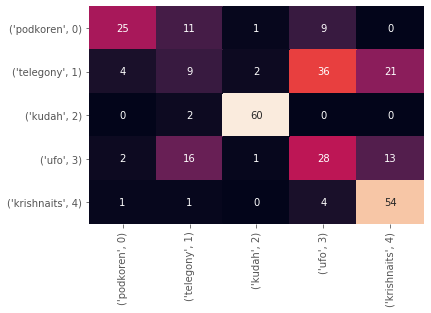

In [221]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.heatmap(data=confusion_matrix(y_test, predicted), annot=True, fmt="d", cbar=False, xticklabels=source2id.items(), yticklabels=source2id.items())

In [222]:
from sklearn.ensemble import RandomForestClassifier

accs = []
micro_f1s = []
micro_ps = []
micro_rs = []
macro_f1s = []
macro_ps = []
macro_rs = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
    forest.fit(X_train, y_train)
    predicted = forest.predict(X_test)
    accs.append(accuracy_score(predicted, y_test))
    micro_f1s.append(f1_score(predicted, y_test, average = 'micro'))
    micro_ps.append(precision_score(predicted, y_test, average = 'micro'))
    micro_rs.append(recall_score(predicted, y_test, average = 'micro'))
    macro_f1s.append(f1_score(predicted, y_test, average = 'macro'))
    macro_ps.append(precision_score(predicted, y_test, average = 'macro'))
    macro_rs.append(recall_score(predicted, y_test, average = 'macro'))

In [223]:
print("Accuracy:", np.mean(accs))
print("Micro F1:", np.mean(micro_f1s))
print("Micro prescision:", np.mean(micro_ps))
print("Micro recall:", np.mean(micro_rs))
print("Macro F1:", np.mean(macro_f1s))
print("Macro prescision:", np.mean(macro_ps))
print("Macro recall:", np.mean(macro_rs))

Accuracy: 0.7716666666666667
Micro F1: 0.7716666666666667
Micro prescision: 0.7716666666666667
Micro recall: 0.7716666666666667
Macro F1: 0.7617674707720935
Macro prescision: 0.7706354144167135
Macro recall: 0.7773368160252409


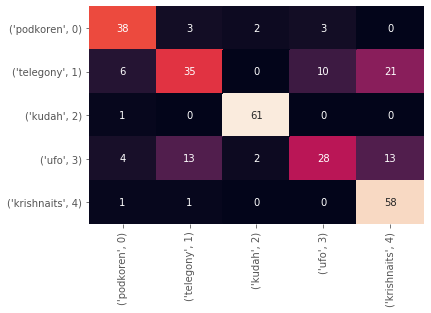

In [224]:
sns.heatmap(data=confusion_matrix(y_test, predicted), annot=True, fmt="d", cbar=False, xticklabels=source2id.items(), yticklabels=source2id.items())

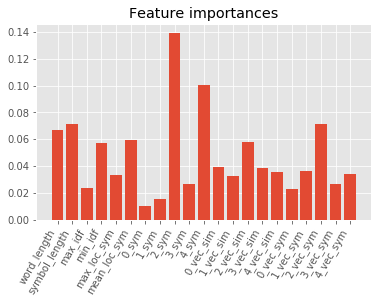

In [225]:
importances = forest.feature_importances_
fig = plt.figure()
plt.title("Feature importances")
plt.bar(X.columns, importances)
plt.xticks(X.columns)
fig.autofmt_xdate(rotation = 60)
plt.show()

In [226]:
import xgboost as xgb

accs = []
micro_f1s = []
micro_ps = []
micro_rs = []
macro_f1s = []
macro_ps = []
macro_rs = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)
    xgb_model.fit(X_train, y_train)
    predicted = xgb_model.predict(X_test)
    accs.append(accuracy_score(predicted.round(), y_test))
    micro_f1s.append(f1_score(predicted.round(), y_test, average = 'micro'))
    micro_ps.append(precision_score(predicted.round(), y_test, average = 'micro'))
    micro_rs.append(recall_score(predicted.round(), y_test, average = 'micro'))
    macro_f1s.append(f1_score(predicted.round(), y_test, average = 'macro'))
    macro_ps.append(precision_score(predicted.round(), y_test, average = 'macro'))
    macro_rs.append(recall_score(predicted.round(), y_test, average = 'macro'))

[17:43:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:43:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:43:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:43:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:43:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:43:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:43:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:43:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [227]:
print("Accuracy:", np.mean(accs))
print("Micro F1:", np.mean(micro_f1s))
print("Micro prescision:", np.mean(micro_ps))
print("Micro recall:", np.mean(micro_rs))
print("Macro F1:", np.mean(macro_f1s))
print("Macro prescision:", np.mean(macro_ps))
print("Macro recall:", np.mean(macro_rs))

Accuracy: 0.556
Micro F1: 0.556
Micro prescision: 0.556
Micro recall: 0.556
Macro F1: 0.5261648493757318
Macro prescision: 0.5285740422119416
Macro recall: 0.6099694042009143


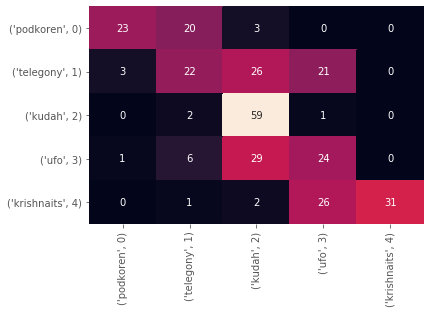

In [228]:
sns.heatmap(data=confusion_matrix(y_test, predicted.round()), annot=True, fmt="d", cbar=False, xticklabels=source2id.items(), yticklabels=source2id.items())

In [229]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

print(pca.n_components_)

accs = []
micro_f1s = []
micro_ps = []
micro_rs = []
macro_f1s = []
macro_ps = []
macro_rs = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
    forest.fit(X_train, y_train)
    predicted = forest.predict(X_test)
    accs.append(accuracy_score(predicted, y_test))
    micro_f1s.append(f1_score(predicted, y_test, average = 'micro'))
    micro_ps.append(precision_score(predicted, y_test, average = 'micro'))
    micro_rs.append(recall_score(predicted, y_test, average = 'micro'))
    macro_f1s.append(f1_score(predicted, y_test, average = 'macro'))
    macro_ps.append(precision_score(predicted, y_test, average = 'macro'))
    macro_rs.append(recall_score(predicted, y_test, average = 'macro'))

2


In [230]:
print("Accuracy:", np.mean(accs))
print("Micro F1:", np.mean(micro_f1s))
print("Micro prescision:", np.mean(micro_ps))
print("Micro recall:", np.mean(micro_rs))
print("Macro F1:", np.mean(macro_f1s))
print("Macro prescision:", np.mean(macro_ps))
print("Macro recall:", np.mean(macro_rs))

Accuracy: 0.5376666666666667
Micro F1: 0.5376666666666667
Micro prescision: 0.5376666666666667
Micro recall: 0.5376666666666667
Macro F1: 0.5250423408033
Macro prescision: 0.5371871196553616
Macro recall: 0.5333071107816016


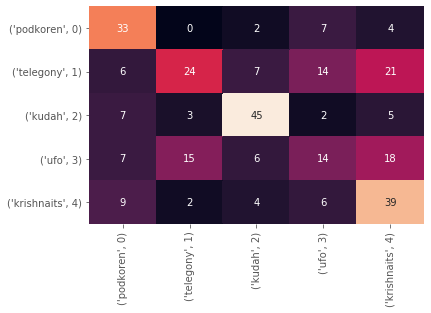

In [231]:
sns.heatmap(data=confusion_matrix(y_test, predicted.round()), annot=True, fmt="d", cbar=False, xticklabels=source2id.items(), yticklabels=source2id.items())